In [1]:
import torch

In [2]:
from utils import assign_splits, get_label_mapping

mbti_to_idx = get_label_mapping(
    file_path="faces_yolo_id_split_metadata.csv",
    label_column="mbti",
)

print("MBTI to index mapping:", mbti_to_idx)

MBTI to index mapping: {'ENFJ': 0, 'ENFP': 1, 'ENTJ': 2, 'ENTP': 3, 'ESFJ': 4, 'ESFP': 5, 'ESTJ': 6, 'ESTP': 7, 'INFJ': 8, 'INFP': 9, 'INTJ': 10, 'INTP': 11, 'ISFJ': 12, 'ISFP': 13, 'ISTJ': 14, 'ISTP': 15}


In [3]:
from torchvision import transforms

train_tf = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(0.25, 0.25, 0.25, 0.05)], p=0.8),
        transforms.RandomApply(
            [
                transforms.RandomAffine(
                    degrees=10,  # small rotation
                    translate=(0.05, 0.05),  # small shifts
                    scale=(0.9, 1.1),
                )
            ],
            p=0.5,
        ),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.ToTensor(),
        transforms.RandomErasing(
            p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3), value="random"
        ),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

val_tf = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [4]:
from torch.utils.data import DataLoader
from dataset import IDSplitCelebMBTIDataset

train_ds = IDSplitCelebMBTIDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    split="train",
    mbti_to_idx=mbti_to_idx,
    transform=train_tf,
)

val_ds = IDSplitCelebMBTIDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    mbti_to_idx=mbti_to_idx,
    split="val",
    transform=val_tf,
)

test_ds = IDSplitCelebMBTIDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    mbti_to_idx=mbti_to_idx,
    split="test",
    transform=val_tf,
)

print(len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)

for images, labels in train_loader:
    print(images.shape)  # [Batch, 3, 224, 224]
    print(labels.shape)  # [Batch, 4]
    break

9573 1201 1205
torch.Size([32, 3, 224, 224])
torch.Size([32])


In [5]:
from models import MBTISingleHeadMulticlass
import torch.nn as nn
from tqdm import tqdm

num_classes = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MBTISingleHeadMulticlass(freeze_backbone=True, num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [6]:
# train on frozen backbone for a few epochs
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-2)

for epoch in range(1, 9):
    # training phase with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)

        # print(logits.shape, y.shape)  # Debugging line
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total_loss += loss.item() * y.size(0)
        total += y.size(0)

        pbar.set_postfix(loss=loss.item())

    tr_loss = total_loss / total
    tr_acc = total_correct / total

    # validation phase with tqdm
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            preds = logits.argmax(1)
            total_correct += (preds == y).sum().item()
            total_loss += loss.item() * y.size(0)
            total += y.size(0)

            pbar.set_postfix(loss=loss.item())

    va_loss = total_loss / total
    va_acc = total_correct / total

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f}/ train accuracy {tr_acc:.3f} | "
        f"val loss {va_loss:.4f}/ val accuracy {va_acc:.3f}"
    )

Epoch 01 | train loss 2.8709/ train accuracy 0.070 | val loss 2.7891/ val accuracy 0.081


Epoch 02 | train loss 2.8077/ train accuracy 0.086 | val loss 2.7697/ val accuracy 0.084


Epoch 03 | train loss 2.7821/ train accuracy 0.095 | val loss 2.7593/ val accuracy 0.091


Epoch 04 | train loss 2.7606/ train accuracy 0.103 | val loss 2.7506/ val accuracy 0.082


Epoch 05 | train loss 2.7464/ train accuracy 0.105 | val loss 2.7488/ val accuracy 0.087


Epoch 06 | train loss 2.7265/ train accuracy 0.120 | val loss 2.7426/ val accuracy 0.081


Epoch 07 | train loss 2.7219/ train accuracy 0.118 | val loss 2.7396/ val accuracy 0.081


Epoch 08 | train loss 2.7159/ train accuracy 0.115 | val loss 2.7369/ val accuracy 0.097


In [7]:

# unfreeze backbone
for param in model.backbone.parameters():
    param.requires_grad = True

train_accs = []
val_accs = []
train_losses = []
val_losses = []

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
best_val_acc = 0.0

for epoch in range(80):
    # training phase with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)

        # print(logits.shape, y.shape)  # Debugging line
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total_loss += loss.item() * y.size(0)
        total += y.size(0)

        pbar.set_postfix(loss=loss.item())

    tr_loss = total_loss / total
    tr_acc = total_correct / total

    # validation phase with tqdm
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            preds = logits.argmax(1)
            total_correct += (preds == y).sum().item()
            total_loss += loss.item() * y.size(0)
            total += y.size(0)

            pbar.set_postfix(loss=loss.item())

    va_loss = total_loss / total
    va_acc = total_correct / total

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f}/ train accuracy {tr_acc:.3f} | "
        f"val loss {va_loss:.4f}/ val accuracy {va_acc:.3f}"
    )

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "best_resnet18_mbti_model.pth")
        print(f"Saved best model with val accuracy: {best_val_acc:.3f}")

Epoch 00 | train loss 2.6994/ train accuracy 0.129 | val loss 2.7365/ val accuracy 0.090
Saved best model with val accuracy: 0.090


Epoch 01 | train loss 2.6971/ train accuracy 0.128 | val loss 2.7364/ val accuracy 0.090


Epoch 02 | train loss 2.6902/ train accuracy 0.130 | val loss 2.7340/ val accuracy 0.089


Epoch 03 | train loss 2.6937/ train accuracy 0.132 | val loss 2.7336/ val accuracy 0.088


Epoch 04 | train loss 2.6918/ train accuracy 0.132 | val loss 2.7325/ val accuracy 0.086


Epoch 05 | train loss 2.6815/ train accuracy 0.135 | val loss 2.7329/ val accuracy 0.083


Epoch 06 | train loss 2.6857/ train accuracy 0.134 | val loss 2.7314/ val accuracy 0.082


Epoch 07 | train loss 2.6793/ train accuracy 0.136 | val loss 2.7333/ val accuracy 0.079


Epoch 08 | train loss 2.6765/ train accuracy 0.137 | val loss 2.7302/ val accuracy 0.091
Saved best model with val accuracy: 0.091


Epoch 09 | train loss 2.6738/ train accuracy 0.139 | val loss 2.7315/ val accuracy 0.084


Epoch 10 | train loss 2.6662/ train accuracy 0.144 | val loss 2.7294/ val accuracy 0.093
Saved best model with val accuracy: 0.093


Epoch 11 | train loss 2.6719/ train accuracy 0.139 | val loss 2.7283/ val accuracy 0.091


Epoch 12 | train loss 2.6728/ train accuracy 0.142 | val loss 2.7275/ val accuracy 0.092


Epoch 13 | train loss 2.6668/ train accuracy 0.133 | val loss 2.7286/ val accuracy 0.088


Epoch 14 | train loss 2.6657/ train accuracy 0.145 | val loss 2.7274/ val accuracy 0.086


Epoch 15 | train loss 2.6569/ train accuracy 0.146 | val loss 2.7284/ val accuracy 0.087


Epoch 16 | train loss 2.6592/ train accuracy 0.140 | val loss 2.7245/ val accuracy 0.094
Saved best model with val accuracy: 0.094


Epoch 17 | train loss 2.6485/ train accuracy 0.152 | val loss 2.7259/ val accuracy 0.091


Epoch 18 | train loss 2.6520/ train accuracy 0.144 | val loss 2.7276/ val accuracy 0.086


Epoch 19 | train loss 2.6538/ train accuracy 0.146 | val loss 2.7257/ val accuracy 0.086


Epoch 20 | train loss 2.6536/ train accuracy 0.147 | val loss 2.7265/ val accuracy 0.089


Epoch 21 | train loss 2.6480/ train accuracy 0.149 | val loss 2.7245/ val accuracy 0.085


Epoch 22 | train loss 2.6444/ train accuracy 0.148 | val loss 2.7249/ val accuracy 0.083


Epoch 23 | train loss 2.6389/ train accuracy 0.146 | val loss 2.7234/ val accuracy 0.087


Epoch 24 | train loss 2.6353/ train accuracy 0.152 | val loss 2.7247/ val accuracy 0.082


Epoch 25 | train loss 2.6388/ train accuracy 0.151 | val loss 2.7264/ val accuracy 0.088


Epoch 26 | train loss 2.6357/ train accuracy 0.153 | val loss 2.7242/ val accuracy 0.088


Epoch 27 | train loss 2.6301/ train accuracy 0.157 | val loss 2.7268/ val accuracy 0.089


Epoch 28 | train loss 2.6327/ train accuracy 0.162 | val loss 2.7258/ val accuracy 0.094


Epoch 29 | train loss 2.6323/ train accuracy 0.158 | val loss 2.7256/ val accuracy 0.093


Epoch 30 | train loss 2.6249/ train accuracy 0.162 | val loss 2.7258/ val accuracy 0.092


Epoch 31 | train loss 2.6281/ train accuracy 0.162 | val loss 2.7240/ val accuracy 0.089


Epoch 32 | train loss 2.6224/ train accuracy 0.162 | val loss 2.7233/ val accuracy 0.091


Epoch 33 | train loss 2.6303/ train accuracy 0.165 | val loss 2.7220/ val accuracy 0.088


Epoch 34 | train loss 2.6208/ train accuracy 0.157 | val loss 2.7258/ val accuracy 0.090


Epoch 35 | train loss 2.6205/ train accuracy 0.163 | val loss 2.7224/ val accuracy 0.088


Epoch 36 | train loss 2.6100/ train accuracy 0.171 | val loss 2.7232/ val accuracy 0.099
Saved best model with val accuracy: 0.099


Epoch 37 | train loss 2.6060/ train accuracy 0.168 | val loss 2.7228/ val accuracy 0.092


Epoch 38 | train loss 2.6097/ train accuracy 0.168 | val loss 2.7226/ val accuracy 0.098


Epoch 39 | train loss 2.6106/ train accuracy 0.163 | val loss 2.7247/ val accuracy 0.091


Epoch 40 | train loss 2.6103/ train accuracy 0.169 | val loss 2.7227/ val accuracy 0.090


Epoch 41 | train loss 2.6071/ train accuracy 0.171 | val loss 2.7256/ val accuracy 0.092


Epoch 42 | train loss 2.6020/ train accuracy 0.173 | val loss 2.7223/ val accuracy 0.095


Epoch 43 | train loss 2.5959/ train accuracy 0.172 | val loss 2.7241/ val accuracy 0.092


Epoch 44 | train loss 2.5949/ train accuracy 0.173 | val loss 2.7233/ val accuracy 0.097


Epoch 45 | train loss 2.5938/ train accuracy 0.174 | val loss 2.7233/ val accuracy 0.096


Epoch 46 | train loss 2.5966/ train accuracy 0.174 | val loss 2.7258/ val accuracy 0.091


Epoch 47 | train loss 2.5950/ train accuracy 0.185 | val loss 2.7232/ val accuracy 0.094


Epoch 48 | train loss 2.5896/ train accuracy 0.182 | val loss 2.7239/ val accuracy 0.089


Epoch 49 | train loss 2.5885/ train accuracy 0.177 | val loss 2.7268/ val accuracy 0.091


Epoch 50 | train loss 2.5836/ train accuracy 0.182 | val loss 2.7263/ val accuracy 0.095


Epoch 51 | train loss 2.5869/ train accuracy 0.178 | val loss 2.7254/ val accuracy 0.100
Saved best model with val accuracy: 0.100


Epoch 52 | train loss 2.5755/ train accuracy 0.187 | val loss 2.7233/ val accuracy 0.093


Epoch 53 | train loss 2.5810/ train accuracy 0.180 | val loss 2.7227/ val accuracy 0.097


Epoch 54 | train loss 2.5749/ train accuracy 0.183 | val loss 2.7252/ val accuracy 0.093


Epoch 55 | train loss 2.5710/ train accuracy 0.186 | val loss 2.7255/ val accuracy 0.097


Epoch 56 | train loss 2.5687/ train accuracy 0.189 | val loss 2.7267/ val accuracy 0.091


Epoch 57 | train loss 2.5723/ train accuracy 0.185 | val loss 2.7248/ val accuracy 0.096


Epoch 58 | train loss 2.5674/ train accuracy 0.185 | val loss 2.7248/ val accuracy 0.096


Epoch 59 | train loss 2.5709/ train accuracy 0.182 | val loss 2.7263/ val accuracy 0.090


Epoch 60 | train loss 2.5615/ train accuracy 0.192 | val loss 2.7263/ val accuracy 0.097


Epoch 61 | train loss 2.5635/ train accuracy 0.192 | val loss 2.7282/ val accuracy 0.094


Epoch 62 | train loss 2.5630/ train accuracy 0.192 | val loss 2.7265/ val accuracy 0.105
Saved best model with val accuracy: 0.105


Epoch 63 | train loss 2.5612/ train accuracy 0.193 | val loss 2.7261/ val accuracy 0.102


Epoch 64 | train loss 2.5538/ train accuracy 0.196 | val loss 2.7284/ val accuracy 0.105


Epoch 65 | train loss 2.5466/ train accuracy 0.201 | val loss 2.7258/ val accuracy 0.102


Epoch 66 | train loss 2.5571/ train accuracy 0.194 | val loss 2.7286/ val accuracy 0.101


Epoch 67 | train loss 2.5504/ train accuracy 0.195 | val loss 2.7262/ val accuracy 0.099


Epoch 68 | train loss 2.5491/ train accuracy 0.204 | val loss 2.7293/ val accuracy 0.099


Epoch 69 | train loss 2.5493/ train accuracy 0.198 | val loss 2.7279/ val accuracy 0.095


Epoch 70 | train loss 2.5482/ train accuracy 0.203 | val loss 2.7302/ val accuracy 0.097


Epoch 71 | train loss 2.5397/ train accuracy 0.202 | val loss 2.7303/ val accuracy 0.094


Epoch 72 | train loss 2.5374/ train accuracy 0.204 | val loss 2.7280/ val accuracy 0.100


Epoch 73 | train loss 2.5386/ train accuracy 0.206 | val loss 2.7269/ val accuracy 0.102


Epoch 74 | train loss 2.5368/ train accuracy 0.210 | val loss 2.7290/ val accuracy 0.102


Epoch 75 | train loss 2.5323/ train accuracy 0.208 | val loss 2.7314/ val accuracy 0.098


Epoch 76 | train loss 2.5309/ train accuracy 0.209 | val loss 2.7285/ val accuracy 0.093


Epoch 77 | train loss 2.5277/ train accuracy 0.207 | val loss 2.7303/ val accuracy 0.098


Epoch 78 | train loss 2.5315/ train accuracy 0.212 | val loss 2.7285/ val accuracy 0.099


Epoch 79 | train loss 2.5227/ train accuracy 0.214 | val loss 2.7300/ val accuracy 0.097


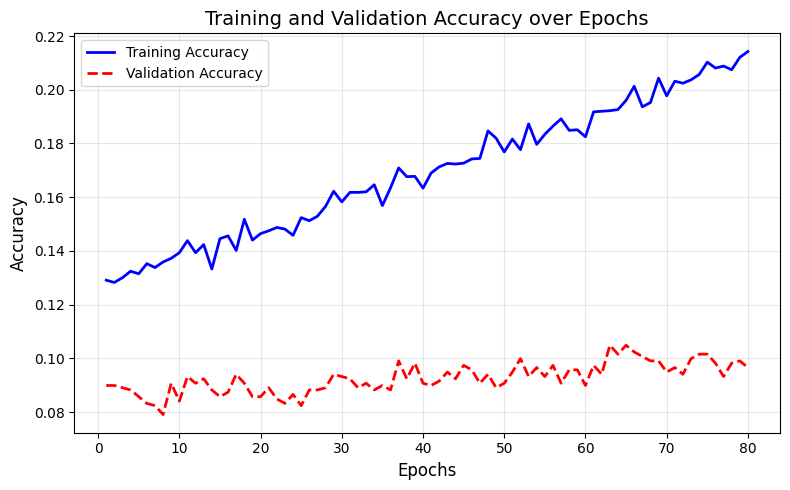

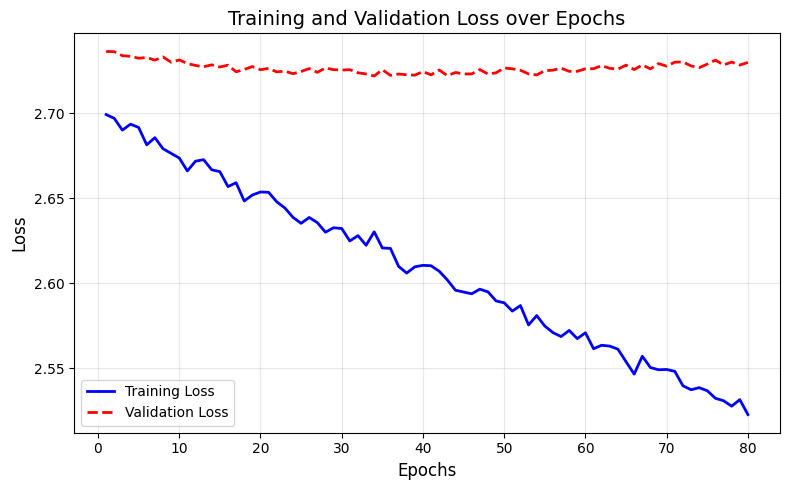

In [8]:
import matplotlib.pyplot as plt
from utils import plot_metric, plot_confusion_matrix

plot_metric(
    train_values=train_accs,
    val_values=val_accs,
    title="Training and Validation Accuracy over Epochs",
    ylabel="Accuracy",
)

plot_metric(
    train_values=train_losses,
    val_values=val_losses,
    title="Training and Validation Loss over Epochs",
    ylabel="Loss",
)

Generating predictions for Confusion Matrix...


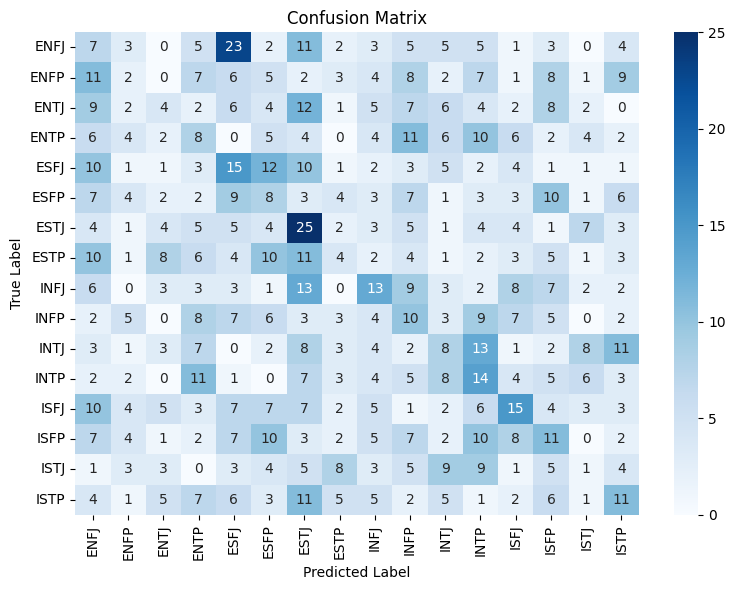


--- Per-Class Accuracy ---
ENFJ: 8.86%
ENFP: 2.63%
ENTJ: 5.41%
ENTP: 10.81%
ESFJ: 20.83%
ESFP: 10.96%
ESTJ: 32.05%
ESTP: 5.33%
INFJ: 17.33%
INFP: 13.51%
INTJ: 10.53%
INTP: 18.67%
ISFJ: 17.86%
ISFP: 13.58%
ISTJ: 1.56%
ISTP: 14.67%


In [9]:
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

plot_confusion_matrix(
    model=model,
    loader=test_dl,
    device=device,
    class_names=list(mbti_to_idx.keys())
)

In [10]:
torch.save(model.state_dict(), "resnet_mbti_classification.pth")